In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, SubsetRandomSampler,DataLoader
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
# from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
import random

In [2]:
!unzip /content/drive/MyDrive/Inian_sign_language.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/V/819.jpg          
  inflating: data/V/82.jpg           
  inflating: data/V/820.jpg          
  inflating: data/V/821.jpg          
  inflating: data/V/822.jpg          
  inflating: data/V/823.jpg          
  inflating: data/V/824.jpg          
  inflating: data/V/825.jpg          
  inflating: data/V/826.jpg          
  inflating: data/V/827.jpg          
  inflating: data/V/828.jpg          
  inflating: data/V/829.jpg          
  inflating: data/V/83.jpg           
  inflating: data/V/830.jpg          
  inflating: data/V/831.jpg          
  inflating: data/V/832.jpg          
  inflating: data/V/833.jpg          
  inflating: data/V/834.jpg          
  inflating: data/V/835.jpg          
  inflating: data/V/836.jpg          
  inflating: data/V/837.jpg          
  inflating: data/V/838.jpg          
  inflating: data/V/839.jpg          
  inflating: data/V/84.jpg           
  inflating: data/V/840.jpg          

In [3]:
class IndianSignLanguageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = sorted(os.listdir(root_dir))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
        self.image_paths = []
        for label in self.labels:
            label_dir = os.path.join(root_dir, label)
            for image_path in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label, image_path))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.image_paths[index])
        image = Image.open(image_path).convert('RGB')
        label = self.label_to_idx[image_path.split(os.sep)[-2]]
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
# Define the transforms to be applied to the dataset
transform = transforms.Compose(
    [transforms.Resize((128, 128)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-30, 30)),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-10, 10)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Create the dataset
my_dataset = IndianSignLanguageDataset(root_dir="/content/data", transform=transform)


# Shuffle the dataset
shuffled_indices = torch.randperm(len(my_dataset)).tolist()
my_dataset = torch.utils.data.Subset(my_dataset, shuffled_indices)

# # Define the size of the training set
# train_size = int(0.8 * len(my_dataset))
# test_size = len(my_dataset) - train_size

# # Define the indices for the training and testing sets
# train_indices, test_indices = shuffled_indices[:train_size], shuffled_indices[train_size:]
# Define the size of the training, validation, and testing sets
train_size = int(0.7 * len(my_dataset))
val_size = int(0.1 * len(my_dataset))
test_size = len(my_dataset) - train_size - val_size

# Define the indices for the training, validation, and testing sets
train_indices = shuffled_indices[:train_size]
val_indices = shuffled_indices[train_size:train_size + val_size]
test_indices = shuffled_indices[train_size + val_size:]

In [5]:
# Create the data samplers for the training and testing sets
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [6]:
# Create the data loaders for the training and testing sets
train_loader = DataLoader(my_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(my_dataset, batch_size=64, sampler=test_sampler)
val_loader = DataLoader(my_dataset, batch_size=64, sampler=val_sampler)

In [7]:
!pip install efficientnet_pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=488731d47d9b4ce5afd686e1f8c4d0ac3242307cc6ea646378db982f9400bb43
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [8]:
from efficientnet_pytorch import EfficientNet

# Load pre-trained model and freeze layers
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=26)
for param in model.parameters():
    param.requires_grad = False

# Replace last fully connected layer with a new one
num_ftrs = model._fc.in_features
model._fc = nn.Linear(1280, 36)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 163MB/s]

Loaded pretrained weights for efficientnet-b0


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
import random
import torch.nn.functional as F
from tqdm import tqdm

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

# Define the L1 regularization strength
l1_lambda = 0.001

# Train the model
train_losses = []
val_losses = []
train_total = 0
train_correct = 0
val_total = 0
val_correct = 0

for epoch in range(2):
    # Training steps...
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    for i, data in enumerate(progress_bar, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Calculate the loss

        # L1 regularization
        l1_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l1_regularization += torch.norm(param, p=1)

        loss += l1_lambda * l1_regularization

        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Optimize the weights
        running_loss += loss.item()
        train_losses.append(loss.item())  # Store all losses after each batch

        # Update total and correct variables for training accuracy
        train_total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_accuracy = 100 * train_correct / train_total
        progress_bar.set_postfix(loss=running_loss / (i+1), acc=train_accuracy)

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            # Compute test accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate loss for the batch and update running loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            val_losses.append(loss.item())

    # Compute test accuracy and loss for the epoch
    val_accuracy = 100 * val_correct / val_total
    val_loss = running_loss / len(val_loader)
    # val_losses.append(val_loss)

    # Print test accuracy and loss for the epoch
    # print('Epoch %d, val Loss: %.3f, val Accuracy: %.3f' % (epoch + 1, val_loss, val_accuracy))

    # Compute and print training accuracy
    train_accuracy = 100 * train_correct / train_total
    print('Epoch %d, Training Accuracy: %.3f' % (epoch + 1, train_accuracy))


Epoch 1: 100%|██████████| 460/460 [26:10<00:00,  3.41s/it, acc=93.9, loss=298]


Epoch 1, Training Accuracy: 93.949


Epoch 2: 100%|██████████| 460/460 [18:57<00:00,  2.47s/it, acc=96.6, loss=297]


Epoch 2, Training Accuracy: 96.566


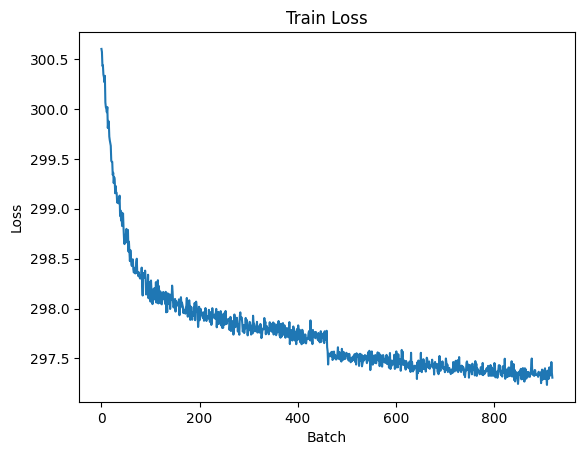

In [14]:
import matplotlib.pyplot as plt

# Plot train losses
plt.plot(train_losses)
plt.title("Train Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()



In [15]:
# Save the model, optimizer, and training history to a checkpoint file
checkpoint = {'modelfinal1_final': model.state_dict(),
              'optimizerfinal1-final': optimizer.state_dict(),
              'train_lossesfinal1-final': train_losses}
torch.save(checkpoint, 'checkpointfinal2-final.pth')


In [22]:
# optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Load the saved model and optimizer states
model.load_state_dict(checkpoint['modelfinal1_final'])
optimizer.load_state_dict(checkpoint['optimizerfinal1-final'])

In [16]:
# Load the checkpoint file
checkpoint = torch.load('checkpointfinal2-final.pth')

# # # Create a new model and optimizer
# model = CNN().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Load the saved model and optimizer states
model.load_state_dict(checkpoint['modelfinal1_final'])
# optimizer.load_state_dict(checkpoint['optimizerfinal1'])
# Put the model in evaluation mode
# model.eval()

class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Create empty lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Loop through the test data and make predictions
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.tolist()
        pred_labels += predicted.tolist()

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=range(len(class_names)))

# Calculate the overall and classwise accuracy
acc = accuracy_score(true_labels, pred_labels)*100
report = classification_report(true_labels, pred_labels,target_names=class_names)

print(f"Confusion Matrix:\n{cm}")
print(f"\nOverall Accuracy: {acc}")
print(f"\nClassification Report:\n{report}")

Confusion Matrix:
[[225   0   0 ...   0   0   0]
 [  0 236   6 ...   0   0   0]
 [  0   0 213 ...   0   0   0]
 ...
 [  0   0   0 ... 226   0   0]
 [  0   0   0 ...   0 248   0]
 [  0   0   0 ...   0   0 253]]

Overall Accuracy: 99.1786692060469

Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       227
           2       1.00      0.98      0.99       242
           3       0.96      0.97      0.97       219
           4       0.99      0.99      0.99       266
           5       0.98      1.00      0.99       242
           6       1.00      0.98      0.99       235
           7       0.99      1.00      1.00       211
           8       1.00      0.99      0.99       241
           9       0.99      0.99      0.99       233
           A       1.00      1.00      1.00       252
           B       0.99      0.99      0.99       232
           C       0.99      0.98      0.99       260
           D       0.97    

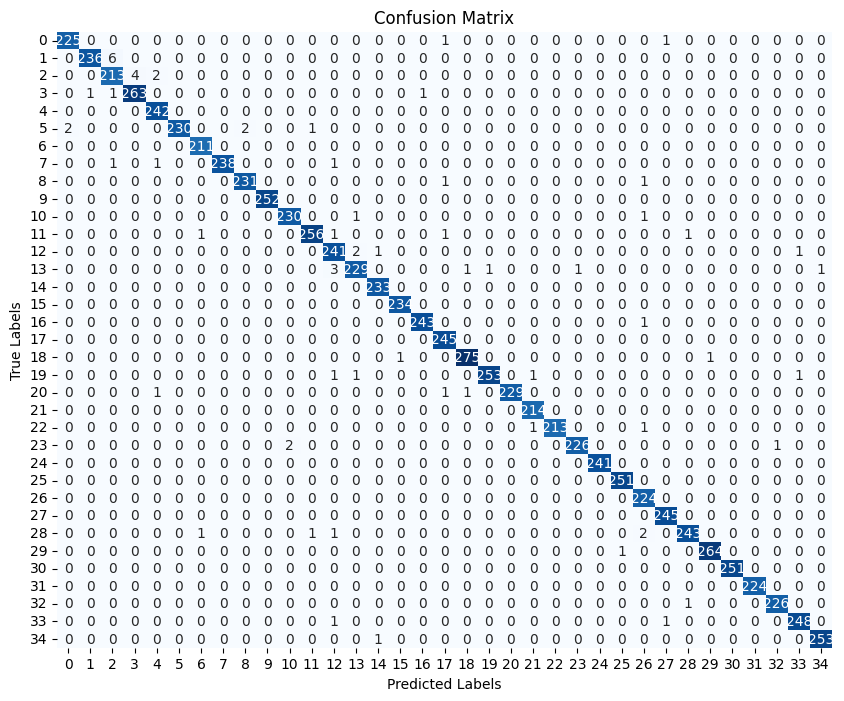

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

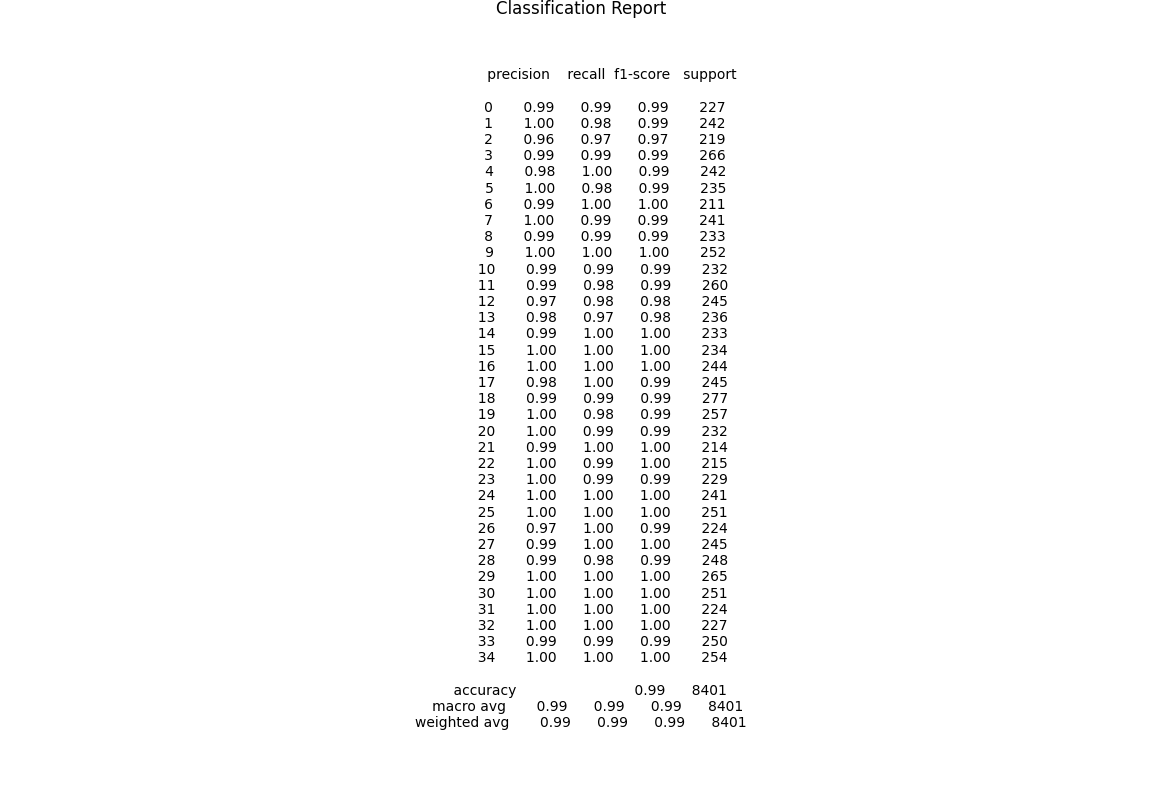

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

# Create a text-based classification report
classification_report_text = classification_report(true_labels, pred_labels)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 10))

# Hide the axes
ax.axis('off')

# Set the title and display the classification report as text
ax.set_title('Classification Report')
ax.text(0.5, 0.5, classification_report_text, ha='center', va='center')

# Save the figure as an image
plt.savefig('classification_report.png', bbox_inches='tight', pad_inches=0)

# Close the figure
plt.close(fig)

# Open the saved image using PIL
image = Image.open('classification_report.png')
image.show()
